In [11]:
import pandas as pd
import os
from sklearn.metrics import f1_score

#Testing was done by gathering predictions from multiple models in a .csv file
#This notebook merely turns the predictions into scores

preds_path = "wsd_data/testing_dump/nn_testing.csv" #predictions with senttransformers
#preds_path = "wsd_data/testing_dump/nn_top4.csv" #predictions with pooled top 4 layers etc.

preds = pd.read_csv(preds_path)
target_berts = [i for i in os.listdir("wsd_data/BERTS") if "." not in i]
del preds["Unnamed: 0"]
preds.columns = target_berts
test_df = pd.read_csv("wsd_data/slo_sense_1.5_splits/test_nopair_fix.csv")

def report(y_true, y_pred):
    f1_micro = f1_score(y_true, y_pred, average = 'micro')
    f1_macro = f1_score(y_true, y_pred, average = 'macro')
    print("{}\t{}".format(round(f1_micro,3), round(f1_macro,3)))
    
def pos_report(y_true, y_pred):
    #f1_scores = pd.Series(f1_score(y_true, y_pred, labels = np.unique(y_true), average = None))
    report_df = test_df[["senseID", "pos"]].copy()
    report_df["predicted"] = y_pred
    report_df["true"] = y_true
    rep_df = report_df.groupby("pos")
    print(rep_df.groups.keys())
    rep_df.apply(lambda x: report(x["true"], x["predicted"]))
    
for i in target_berts:
    print(i)
    report(test_df.senseID, preds[i])
    pos_report(test_df.senseID, preds[i])



trained_20E_nostop
0.489	0.454
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.432	0.249
0.487	0.205
0.505	0.369
0.523	0.341
trained_20S
0.506	0.46
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.485	0.24
0.471	0.175
0.526	0.359
0.492	0.239
big_early_ssbert
0.639	0.587
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.624	0.351
0.613	0.286
0.655	0.485
0.628	0.362
trained_10S
0.408	0.365
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.389	0.179
0.378	0.123
0.424	0.272
0.404	0.18
trained_10E
0.4	0.369
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.348	0.176
0.397	0.141
0.422	0.289
0.415	0.232
trained_20mix
0.477	0.435
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.448	0.224
0.461	0.171
0.487	0.335
0.494	0.261
trained_20E
0.23	0.202
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.194	0.084
0.17	0.045
0.255	0.158
0.23	0.093
cse_bert
0.158	0.137
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.134	0.057
0.111	0.03
0.176	0.108
0.159	0.063


In [5]:
#example core for predicting test df labels (binary classification head) in ipynb
#identical for main and oov testing
#best done detached in tmux

import os
import pandas as pd
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification, BertForNextSentencePrediction
import torch
from tqdm import tqdm #.progress_apply()
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import log_loss
tqdm.pandas(desc='Working on OOV eval') 

target_bert = "wsd_data/BERTS/cse_bert" # "wsd_data/big_early_ssbert"; 
tokenizer_path = "wsd_data/BERTS/cse_bert"
MAXLEN = 180

test_df = pd.read_csv("wsd_data/oov_clean/oov_df.csv") #"wsd_data/combo_dfs/combo_ready/combo_test_fin.csv"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, truncation = True, padding = "max_length", max_length = MAXLEN)
#model = BertForSequenceClassification.from_pretrained(target_bert)
model = BertForSequenceClassification.from_pretrained(target_bert)

#dobiti predictione
def apply_classi(s1, s2):
    encoded_input = tokenizer(s1, s2, padding=True, truncation=True, max_length=128, return_tensors='pt')
    labels = torch.LongTensor([0])
    predict = model(**encoded_input, labels=labels) #
    return int(torch.argmax(predict.logits))

def metrics_pls(true, pred):
    print(["f1", "f1_w", "mcc", "neg_log_loss"])
    print(round(f1_score(true, pred), 3))
    print(round(f1_score(true, pred, average = "weighted"), 3))
    print(round(matthews_corrcoef(true, pred),3))
    print(round(log_loss(true, pred),3))
    
#test_df["pred_label"] = test_df.progress_apply(lambda x: apply_classi(x.sent1, x.sent2), axis = 1)

test_df["pred_label"] = test_df.progress_apply(lambda x: apply_classi(x.text1, x.text2), axis = 1)

#oov has different col names
#metrics_pls(test_df["label"], test_df["pred_label"])
metrics_pls(test_df["labels"], test_df["pred_label"])

Some weights of the model checkpoint at wsd_data/BERTS/cse_bert were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpo

['f1', 'f1_w', 'mcc', 'neg_log_loss']
0.619
0.422
-0.095
18.613


In [39]:
#classification for BERT models with a binary classification head
#test multiple models
#used in tmux

import os
import pandas as pd
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification, BertForNextSentencePrediction
import torch
from tqdm import tqdm #.progress_apply()
from tqdm.notebook import tqdm_notebook
import torch
import torch.nn.functional as nnf


target_berts = ['trained_20S', 'trained_10S','trained_10E', 'trained_20mix', 'trained_20E']
model_path = "wsd_data/BERTS/"
tokenizer_path = "wsd_data/BERTS/cse_bert"
MAXLEN = 180

test_df = pd.read_csv("wsd_data/combo_dfs/combo_ready/combo_test_fin.csv")
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, truncation = True, padding = "max_length", max_length = MAXLEN)

def model_init(target_bert): #needs full path
    return BertForSequenceClassification.from_pretrained(target_bert)

#get predictions
def apply_classi(s1, s2):
    encoded_input = tokenizer(s1, s2, padding=True, truncation=True, max_length=180, return_tensors='pt')
    labels = torch.LongTensor([0])
    predict = model(**encoded_input, labels=labels) #
    probabilities = nnf.softmax(predict.logits, dim=1)
    pos_prob = float(probabilities[0][1])
    classification = int(torch.argmax(predict.logits))
    return [pos_prob, classification]

result_holder = pd.DataFrame([])

for model_name in target_berts:
    tqdm.pandas(desc = 'Working on {}'.format(model_name)) 
    temp_df = pd.DataFrame()
    model = model_init(model_path + model_name)
    encoded = test_df.progress_apply(lambda x: apply_classi(x.sent1, x.sent2), axis = 1, result_type="expand")
    encoded.columns = ["{}_prob".format(model_name).strip("trained_"),"{}_label".format(model_name).strip("trained_")]
    result_holder = pd.concat([result_holder, encoded], axis = 1)
    
#result_holder.to_csv("wsd_data/testing_dump/all_reslts_plz.csv")


Working on BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49601, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

Working on BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49601, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

): 100%|██████████| 3/3 [00:00<00:00, 20.36it/s]
Working on BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49601, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
   

Working on BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49601, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

Working on BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49601, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

): 100%|██████████| 3/3 [00:00<00:00, 18.67it/s]
Working on BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49601, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
   

Working on BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49601, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

): 100%|██████████| 3/3 [00:00<00:00, 20.65it/s]
Working on BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49601, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
   

Working on BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49601, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

): 100%|██████████| 3/3 [00:00<00:00, 20.66it/s]
Working on BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49601, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
   

Working on BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(49601, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

): 100%|██████████| 3/3 [00:00<00:00, 20.60it/s]


In [35]:
import pandas as pd
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from tqdm import tqdm
tqdm.pandas()

res = pd.read_csv("wsd_data/testing_dump/all_reslts_plz.csv")
print(res.columns)
combo_df = pd.read_csv("wsd_data/combo_dfs/combo_ready/combo_test_fin.csv")
test_df = pd.read_csv("wsd_data/slo_sense_1.5_splits/test_nopair_fix.csv")
combo_df = pd.concat([combo_df, res], axis=1)

def pred_labels(sentID, senseID, target_prob):
    all_tar_sents = combo_df[(combo_df.sent1_ind == sentID) + (combo_df.sent2_ind == sentID)]
    probs = all_tar_sents.groupby("senseID2x")[target_prob].mean()
    combo_label = probs[[probs.argmax()]].index[0]
    pred_label = combo_label.replace(senseID, "", 1).replace("_", "")
    return pred_label

def report(y_true, y_pred):
    f1_micro = f1_score(y_true, y_pred, average = 'micro')
    f1_macro = f1_score(y_true, y_pred, average = 'macro')
    print("{}\t{}".format(round(f1_micro,3), round(f1_macro,3)))
    
def pos_report(y_true, y_pred):
    #f1_scores = pd.Series(f1_score(y_true, y_pred, labels = np.unique(y_true), average = None))
    report_df = test_df[["senseID", "pos"]].copy()
    report_df["predicted"] = y_pred
    report_df["true"] = y_true
    rep_df = report_df.groupby("pos")
    print(rep_df.groups.keys())
    rep_df.apply(lambda x: report(x["true"], x["predicted"]))

prob_list = ['10S_prob', "20S_prob", '10E_prob', "20E_prob", "20mix_prob"]

for prob in prob_list:
    predicted_labels = test_df.apply(lambda x: pred_labels(x.sentID, x.senseID, prob), axis = 1)
    print("##")
    print(prob)
    print("f1-micro f1-macro whole")
    report(test_df.senseID, predicted_labels)
    print("f1-micro f1-macro by pos")
    pos_report(test_df.senseID, predicted_labels)
    print("##")
    print(prob)
    print("MKK")
    mkk = matthews_corrcoef(combo_df.label, combo_df[prob].apply(lambda x: int(x)))
    print(round(mkk, 3))
    print("##")



##
10S_prob
f1-micro f1-macro whole
0.814	0.772
f1-micro f1-macro by pos
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.836	0.793
0.812	0.764
0.813	0.771
0.786	0.746
##
##
20S_prob
f1-micro f1-macro whole
0.805	0.755
f1-micro f1-macro by pos
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.836	0.787
0.818	0.76
0.794	0.746
0.788	0.741
##
##
10E_prob
f1-micro f1-macro whole
0.687	0.662
f1-micro f1-macro by pos
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.671	0.646
0.682	0.648
0.714	0.687
0.64	0.613
##
##
20E_prob
f1-micro f1-macro whole
0.806	0.775
f1-micro f1-macro by pos
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.816	0.789
0.803	0.77
0.814	0.782
0.773	0.74
##
##
20mix_prob
f1-micro f1-macro whole
0.816	0.775
f1-micro f1-macro by pos
dict_keys(['ADJ', 'ADV', 'NOUN', 'VERB'])
0.837	0.792
0.83	0.776
0.814	0.776
0.789	0.748
##


In [ ]:
#most frequent sense implementation

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns
import pandas as pd
import numpy as np

pth = "wsd_data/slo_sense_1.5_splits/"
train_df = pd.read_csv(pth + 'train_nopair.csv')
val_df = pd.read_csv(pth + 'val_nopair.csv')
test_df = pd.read_csv(pth + "test_nopair_fix.csv")

mfs_source = pd.concat([train_df, val_df])
lemma_mfs = mfs_source.groupby("lemma")["senseID"].agg(lambda x: x.value_counts().index[0])
mfs_dict = dict(lemma_mfs)
mfs_predictions = test_df.lemma.apply(lambda x: mfs_dict[x])

label_encoder = LabelEncoder()
sense_set = np.unique(train_df["senseID"])
label_encoder.fit(sense_set)


y_true = label_encoder.transform(test_df["senseID"])
y_pred = label_encoder.transform(pd.Series(mfs_predictions))

labels = np.unique(y_true) #f1 bi računal statistike tudi za labele, ki niso v testing setu

def report(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average = 'micro')
    f1_macro = f1_score(y_true, y_pred, average = 'macro')
    print("f1:{}".format(round(f1,3)))
    print("f1-macro:{}".format(round(f1_macro,3)))
    
def pos_report(y_true, y_pred, test_df):
    #f1_scores = pd.Series(f1_score(y_true, y_pred, labels = np.unique(y_true), average = None))
    report_df = test_df[["senseID", "pos"]].copy()
    report_df["predicted"] = y_pred
    report_df["true"] = y_true
    report_df.groupby("pos").apply(lambda x: report(x["true"], x["predicted"]))

print("overall pref")
report(y_true, y_pred)

print(test_df.groupby("pos").groups.keys())
pos_report(y_true, y_pred, test_df)

In [14]:
#Friedman test and post-hoc testing

from scipy import stats
import scikit_posthocs as sp
import numpy as np
 
# Data groups
#am, MFS ven vržem?
#!+activ    
mfs = [40.4, 21.6, 43.6, 33.6, 39.2, 41.5]
slo_100 = [81, 75.8, 84.7, 81.9, 79.6, 79.4]
slo_10 = [81.4, 77.2, 83.6, 81.2, 81.3, 78.6]
slo_20 = [80.5, 75.5, 83.6,81.8, 79.4, 78.8]
eng_10 = [68.7, 66.2, 67.1, 68.2, 71.4, 64]
eng_20_nostop = [46.9, 44.7, 46.8, 47.8, 49.3, 40.6]
eng_20_stop = [80.6, 77.5, 81.6, 80.3, 81.4, 77.3]
mix_20 = [81.6, 77.5, 83.7, 83, 81.4, 78.9]

ft = stats.friedmanchisquare(mfs, slo_100, slo_10, slo_20, eng_10, eng_20_nostop, eng_20_stop, mix_20)

data = np.array([mfs, slo_100, slo_10, slo_20, eng_10, eng_20_nostop, eng_20_stop, mix_20])

ph = sp.posthoc_nemenyi_friedman(data.T)
print(ft)
ph

FriedmanchisquareResult(statistic=36.117764471057875, pvalue=6.887607468697022e-06)


,0,1,2,...,5,6,7
0,1.000000,0.004042,0.026252,...,0.900000,0.063951,0.001000
1,0.004042,1.000000,0.900000,...,0.021695,0.900000,0.900000
2,0.026252,0.900000,1.000000,...,0.102710,0.900000,0.900000
3,0.137420,0.900000,0.900000,...,0.364808,0.900000,0.587337
4,0.900000,0.206098,0.516881,...,0.900000,0.693026,0.031658
5,0.900000,0.021695,0.102710,...,1.000000,0.206098,0.001584
6,0.063951,0.900000,0.900000,...,0.206098,1.000000,0.763485
7,0.001000,0.900000,0.900000,...,0.001584,0.763485,1.000000


RankResult(rankdf=
           meanrank       mean       std   ci_lower   ci_upper effect_size  \
Np         7.833333  36.650000  8.101790  21.681004  51.618996         0.0   
Ang20_bzu  7.166667  46.016667  3.047239  40.386539  51.646794   -1.530339   
Ang10      6.000000  67.600000  2.497198  62.986136  72.213864   -5.162817   
Slo20      4.083333  79.933333  2.773926  74.808183  85.058484   -7.147991   
Ang20_zu   3.666667  79.783333  1.909363  76.255564  83.311103   -7.328405   
Slo10      3.250000  80.550000  2.281885  76.333953  84.766047   -7.376016   
Slo100     2.500000  80.400000  2.963106  74.925317  85.874683   -7.172179   
Meš20      1.500000  81.016667  2.386141  76.607995  85.425338   -7.428952   

            magnitude  
Np         negligible  
Ang20_bzu       large  
Ang10           large  
Slo20           large  
Ang20_zu        large  
Slo10           large  
Slo100          large  
Meš20           large  
pvalue=6.887607468697022e-06
cd=4.286284053731788
omnibus=frie

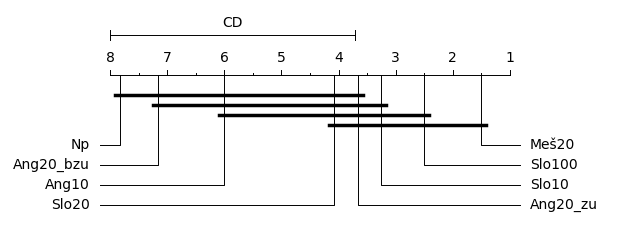

In [1]:
from scipy import stats
import scikit_posthocs as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from autorank import autorank, plot_stats
#alternative for post-hoc testing, inclused critical distance plot

Np = [40.4, 21.6, 43.6, 33.6, 39.2, 41.5]
Slo100 = [81, 75.8, 84.7, 81.9, 79.6, 79.4]
Slo10 = [81.4, 77.2, 83.6, 81.2, 81.3, 78.6]
Slo20 = [80.5, 75.5, 83.6,81.8, 79.4, 78.8]
Ang10 = [68.7, 66.2, 67.1, 68.2, 71.4, 64]
Ang20_bzu = [46.9, 44.7, 46.8, 47.8, 49.3, 40.6]
Ang20_zu = [80.6, 77.5, 81.6, 80.3, 81.4, 77.3]
Meš20 = [81.6, 77.5, 83.7, 83, 81.4, 78.9]

data = pd.DataFrame()

for name, vals in zip("Np, Slo100, Slo10, Slo20, Ang10, Ang20_bzu, Ang20_zu, Meš20".split(", "), [Np, Slo100, Slo10, Slo20, Ang10, Ang20_bzu, Ang20_zu, Meš20]):
    data["{}".format(name)] = vals

result = autorank(data, alpha=0.05, verbose=False)
print(result)

plot_stats(result)
plt.show()

In [27]:
#post-hoc testing for Matthews correlation coefficients
#abandoned, only two measures per model (too few for recommended post-hocs)

s100 = [0.629, 0.273]
s10 = [0.55, 0.292]
s20 = [0.578, 0.284]
a10 = [0.321, 0.268]
a20_nz = [0.004, 0.273]
a20_zu = [0.491, 0.353]
meš20 = [0.578, 0.326]
ft = stats.friedmanchisquare(s100, s10, s20, a10, a20_nz, a20_zu, meš20)
data = np.array([s100, s10, s20, a10, a20_nz, a20_zu, meš20])

ph = sp.posthoc_nemenyi_friedman(data.T)
print(ft[0], ft[1])
ph

mkk_data = np.array([s100, s10, s20, a10, a20_nz, a20_zu, meš20])

mkk_data = pd.DataFrame(mkk_data.T)
mkk_data.columns = "Slo100, Slo10, Slo20, Ang10, Ang20_bzu, Ang20_zu, Meš20".split(", ")

mkk_data

#however, spearman correlation can be performed on the data
from scipy.stats import spearmanr
from scipy.stats import wilcoxon

rankin = [1,3,2,3,2,4,2]
print(spearmanr(rankin, mkk_data.loc[1].rank()))
print(spearmanr(rankin, mkk_data.loc[0].rank()))

7.309090909090904 0.293205993752092


,Slo100,Slo10,Slo20,Ang10,Ang20_bzu,Ang20_zu,Meš20
0,0.629,0.550,0.578,0.321,0.004,0.491,0.578
1,0.273,0.292,0.284,0.268,0.273,0.353,0.326


FriedmanchisquareResult(statistic=36.117764471057875, pvalue=6.887607468697022e-06)
RankResult(rankdf=
           meanrank  median   mad ci_lower ci_upper effect_size   magnitude
Izh        9.000000   21.30   1.2     17.5     22.7         0.0  negligible
Ang20_zu   7.833333   27.95   1.6     23.1     29.9   -3.171631       large
Np         7.166667   39.80  2.75     21.6     43.6   -5.881406       large
Slo10      5.833333   50.55  1.25     43.2     52.5  -16.101835       large
Ang10      4.833333   53.15   1.6     46.1     55.9  -15.190443       large
Meš20      3.500000   60.80   0.2     34.0     61.0  -30.971143       large
Slo20      3.000000   59.90  1.05     52.8     62.7   -23.09127       large
Ang20_bzu  2.833333   60.25  1.05     53.6     64.1  -23.300647       large
Slo100     1.000000   72.25   0.4     65.4     74.2  -38.421578       large
pvalue=3.505769601362535e-07
cd=4.904277471712397
omnibus=friedman
posthoc=nemenyi
all_normal=False
pvals_shapiro=[0.014683691784739494, 

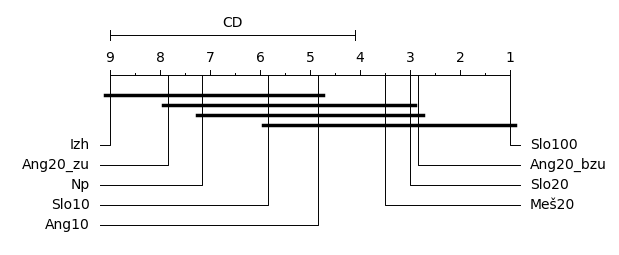

In [22]:
#Friedman & post-hocs for nearest neighbor predictions
from scipy import stats
import scikit_posthocs as sp
import numpy as np

mfs = [40.4, 21.6, 43.6, 33.6, 39.2, 41.5]
base = [21.7, 17.5, 20.9, 17.9, 22.3, 22.7]
slo_100 = [72.8, 65.4, 74.2, 72, 72.5, 72]
slo_10 = [50.9, 43.2, 52.5, 48, 50.2, 51.1]
slo_20 = [60.7, 52.8, 62.7, 58.6, 60.5, 59.3]
eng_10 = [53.2, 46.1, 53.1, 55.2, 52, 55.9]
eng_20_nostop = [60.6, 53.6, 59.2, 61.3, 59.9, 64.1]
eng_20_stop = [28.7, 23.4, 27.2, 23.1, 29.9, 29.2]
mix_20 = [61, 34, 61, 60.6, 58.4, 61]


#ft = stats.friedmanchisquare(mfs, base, slo_100, slo_10, slo_20, eng_10, eng_20_nostop, eng_20_stop, mix_20)
#print(round(ft[0], 2))
#plz_number(ft[1])

data = np.array([mfs, base, slo_100, slo_10, slo_20, eng_10, eng_20_nostop, eng_20_stop, mix_20])
#ph = sp.posthoc_nemenyi_friedman(data.T)
print(ft)
#ph

nn_results = pd.DataFrame(data.T)
nn_results.columns = "Np, Izh, Slo100, Slo10, Slo20, Ang10, Ang20_bzu, Ang20_zu, Meš20".split(", ")
nn_results


result = autorank(nn_results, alpha=0.05, verbose=False)
print(result)

plot_stats(result)
plt.show()

In [74]:
#Framework for using next-sentence prediction for model-neutral testing
#abandoned in favor of NN
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification, BertForNextSentencePrediction
import torch 
import torch.nn.functional as nnf

combo_df = pd.read_csv("wsd_data/combo_dfs/combo_ready/combo_test_fin.csv")
test_df = pd.read_csv("wsd_data/slo_sense_1.5_splits/test_nopair_fix.csv")
target_prob = "pos_prob"

#target_bert = "wsd_data/big_early_ssbert"
target_bert = "wsd_data/BERTS/trained_20E_nostop"
tokenizer_path = "wsd_data/BERTS/cse_bert"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
#model = BertForNextSentencePrediction.from_pretrained(tokenizer_path)
model = BertForSequenceClassification.from_pretrained(tokenizer_path)

def apply_classi(s1, s2):
    encoded_input = tokenizer(s1, s2, padding=True, truncation=True, max_length=180, return_tensors='pt')
    labels = torch.LongTensor([0])
    predict = model(**encoded_input, labels=labels) #
    probabilities = nnf.softmax(predict.logits, dim=1)
    pos_prob = float(probabilities[0][1])
    classification = int(torch.argmax(predict.logits))
    return [pos_prob, classification]

pos_prob_and_labels = combo_df.progress_apply(lambda x: apply_classi(x.sent1, x.sent2), axis = 1,  result_type="expand")
pos_prob_and_labels.columns = ["pos_prob", "pred_label"]
pos_prob_and_labels["pred_label"] = pos_prob_and_labels.pred_label.apply(lambda x: int(x))
combo_df = pd.concat([combo_df, pos_prob_and_labels], axis='columns')



def pred_labels(sentID, senseID, target_prob):
    all_tar_sents = combo_df[(combo_df.sent1_ind == sentID) + (combo_df.sent2_ind == sentID)]
    probs = all_tar_sents.groupby("senseID2x")[target_prob].mean()
    combo_label = probs[[probs.argmax()]].index[0]
    pred_label = combo_label.replace(senseID, "", 1).replace("_", "")
    return pred_label

def report(y_true, y_pred):
    f1_micro = f1_score(y_true, y_pred, average = 'micro')
    f1_macro = f1_score(y_true, y_pred, average = 'macro')
    print("{}\t{}".format(round(f1_micro,3), round(f1_macro,3)))
    
def pos_report(y_true, y_pred):
    #f1_scores = pd.Series(f1_score(y_true, y_pred, labels = np.unique(y_true), average = None))
    report_df = test_df[["senseID", "pos"]].copy()
    report_df["predicted"] = y_pred
    report_df["true"] = y_true
    rep_df = report_df.groupby("pos")
    print(rep_df.groups.keys())
    rep_df.apply(lambda x: report(x["true"], x["predicted"]))

predicted_labels = test_df.apply(lambda x: pred_labels(x.sentID, x.senseID, target_prob), axis = 1)
print("f1-micro macro all")
report(test_df.senseID, predicted_labels)
print("f1-micro f1-macro by pos")
pos_report(test_df.senseID, predicted_labels)
mkk = round(matthews_corrcoef(be.label, be.pred_label), 3)
print(mkk)
print("##")


Some weights of the model checkpoint at wsd_data/BERTS/cse_bert were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 68/68 [00:03<00:00, 18.75it/s]


ValueError: attempt to get argmax of an empty sequence

In [73]:
#mock = combo_df[combo_df.lemma.apply(lambda x: x in [ˇ"Bik", "cirkus"])]
#mock = combo_df[combo_df.lemma == "Bik" | combo_df.lemma == "cirkus"]#| .apply(lambda x: x in [ˇ"Bik", "cirkus"])]
mock = combo_df[combo_df.lemma.isin(['cirkus','Bik'])]

,Unnamed: 0.1,Unnamed: 0,text_pair,sense1,sense2,sent1_ind,sent2_ind,lemma,label,senseID2x,sent1,sent2,pos_prob,pred_label
0,0,2,Luna v 'Biku' prinaša umirjenost [SEP] Luna v ...,Bik%1,Bik%1,8,9,Bik,1,Bik%1_Bik%1,Luna v 'Biku' prinaša umirjenost,Luna v 'Biku' vam pridaja šarm zaradi česar p...,0.993677,1.0
1,1,3,Luna v 'Biku' prinaša umirjenost [SEP] Vpliv S...,Bik%1,Bik%1,8,7,Bik,1,Bik%1_Bik%1,Luna v 'Biku' prinaša umirjenost,Vpliv Sonca v 'Biku' bo prinesel željo po izk...,0.991594,1.0
2,2,4,Luna v 'Biku' prinaša umirjenost [SEP] Po sonč...,Bik%1,Bik%1,8,10,Bik,1,Bik%1_Bik%1,Luna v 'Biku' prinaša umirjenost,Po sončnem horoskopu ima Luno v znamenju 'Bika',0.985806,1.0
3,3,6,Svetloba ki prihaja iz Plejad kupa zvezd iz oz...,Bik%0,Bik%0,0,3,Bik,1,Bik%0_Bik%0,Svetloba ki prihaja iz Plejad kupa zvezd iz oz...,Saturn bo 9 avgusta kot zadnji zapustil ozvez...,0.985138,1.0
4,4,10,Svetloba ki prihaja iz Plejad kupa zvezd iz oz...,Bik%0,Bik%0,0,4,Bik,1,Bik%0_Bik%0,Svetloba ki prihaja iz Plejad kupa zvezd iz oz...,Rakova meglica v ozvezdju 'Bika' je ostanek s...,0.988252,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87875,87875,15045,Kot je dejala specialistka za hitre discipline...,cirkus%1,cirkus%2,6212,6222,cirkus,0,cirkus%1_cirkus%2,Kot je dejala specialistka za hitre discipline...,Avstrijci so naredili cel 'cirkus',0.418848,0.0
87876,87876,15095,Po vsega enajstih mesecih po operaciji je znov...,cirkus%1,cirkus%2,6211,6222,cirkus,0,cirkus%1_cirkus%2,Po vsega enajstih mesecih po operaciji je znov...,Avstrijci so naredili cel 'cirkus',0.221271,0.0
87877,87877,15093,Po vsega enajstih mesecih po operaciji je znov...,cirkus%1,cirkus%2,6211,6220,cirkus,0,cirkus%1_cirkus%2,Po vsega enajstih mesecih po operaciji je znov...,Zaradi tega nastane cel 'cirkus' Barbara pa o...,0.513720,1.0
87878,87878,15076,Američana sta v teniškem 'cirkusu' dosegla sko...,cirkus%1,cirkus%2,6213,6220,cirkus,0,cirkus%1_cirkus%2,Američana sta v teniškem 'cirkusu' dosegla sko...,Zaradi tega nastane cel 'cirkus' Barbara pa o...,0.504384,1.0


In [ ]:
#predictions for out-of-vocabulary testing for binary classification models
#intended for use with tmux

import os
import pandas as pd
from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification, BertForNextSentencePrediction
import torch
from tqdm import tqdm #.progress_apply()
from tqdm.notebook import tqdm_notebook
import torch
import torch.nn.functional as nnf
tqdm.pandas()

oov_pth = "wsd_data/oov_clean/"
oov_df = pd.read_csv(oov_pth + 'oov_df.csv')
model_path = "wsd_data/BERTS/"
tokenizer_path = "wsd_data/BERTS/cse_bert"
MAXLEN = 180
target_berts = ['trained_20S', 'trained_10S','trained_10E', 'trained_20mix', 'trained_20E']
oov_pth = "wsd_data/oov_clean/"
test_df = pd.read_csv(oov_pth + 'oov_df.csv') #OOV_cel
test_df = test_df.rename(columns ={"text1":"sent1", "text2":"sent2"})
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, truncation = True, padding = "max_length", max_length = MAXLEN)

def model_init(target_bert): #needs full path
    return BertForSequenceClassification.from_pretrained(target_bert)

#dobiti predictione
def apply_classi(s1, s2):
    encoded_input = tokenizer(s1, s2, padding=True, truncation=True, max_length=180, return_tensors='pt')
    labels = torch.LongTensor([0])
    predict = model(**encoded_input, labels=labels) #
    classification = int(torch.argmax(predict.logits))
    return classification

result_holder = pd.DataFrame([])

for model_name in target_berts:
    tqdm.pandas(desc = 'Working on {}'.format(model_name)) 
    temp_df = pd.DataFrame()
    model = model_init(model_path + model_name)
    encoded = test_df.progress_apply(lambda x: apply_classi(x.sent1, x.sent2), axis = 1, result_type="expand")
    encoded.columns = ["{}_label".format(model_name).strip("trained_"),"{}_label".format(model_name).strip("trained_")]
    result_holder = pd.concat([result_holder, encoded], axis = 1)

result_holder.columns = ['trained_20S', 'trained_10S','trained_10E', 'trained_20mix', 'trained_20E']
#result_holder.to_csv("wsd_data/testing_dump/oov_results.csv")

for pred_model in target_berts:
    print("##")
    print(pred_model)
    preds = result_holder[pred_model]
    mkk = round(matthews_corrcoef(test_df.labels, preds), 3)
    print(mkk)

In [ ]:
#getting predictions based on nearest neighbor for several models
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import torch
tqdm.pandas()

src1 = pd.read_csv(src_path + "train_nopair.csv")
src2 = pd.read_csv(src_path + "val_nopair.csv")
train_df = pd.concat([src1, src2])
test_df = pd.read_csv(src_path + 'test_nopair_fix.csv')

model_path = "wsd_data/BERTS/"
tokenizer_path = model_path + "cse_bert"
target_berts = os.listdir("wsd_data/BERTS/")


def model_init(target_bert):
    return SentenceTransformer(target_bert)

def query2label(sent, sense_emb_storage):
    query_embedding = model.encode(sent)
    cos_scores = util.cos_sim(query_embedding, sense_emb_storage)[0]
    target_ind = cos_scores.argmax()
    print(cos_scores.argmax())
    return senseID_storage[int(target_ind)]

def generate_preds(model):
    #does the preds for a single model
    senseID_storage = []
    sense_embed_storage = []
    for senseID, group in train_df.groupby("senseID"):
        senseID_storage.append(senseID)
        sent_list = group.sent.to_list()
        embeddings = model.encode(sent_list)
        sense_embed = np.mean(embeddings, axis = 0)
        sense_embed_storage.append(sense_embed)
    nn_preds = test_df.sent.progress_apply(lambda x: query2label(x, sense_embed_storage))
    return nn_preds

for model_name in target_berts:
    tqdm.pandas(desc = 'Working on {}'.format(model_name)) 
    temp_df = pd.DataFrame()
    model = model_init(model_path + model_name)
    encoded = generate_preds(model)
    encoded.columns = ["{}_NNpred".format(model_name)]
    result_holder = pd.concat([result_holder, encoded], axis = 1)
    
result_holder.to_csv("wsd_data/testing_dump/NN_testing.csv")